In [28]:
# для работы с данными
import pandas as pd
import numpy as np

# всякие статистики
from scipy import stats
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

# быстрый вызов эконометрических команд
import statsmodels.api as sm

#!pip install linearmodels
from linearmodels.iv import IV2SLS, compare
from linearmodels.shared.hypotheses import WaldTestStatistic as wald_test

# графики
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
%matplotlib inline

# убрать предупреждения
import warnings
warnings.filterwarnings("ignore")

In [29]:
data = pd.read_csv('Data_with_new_feature.csv')
data['log_price'] = np.log(data['price'])
data['log_tirage'] = np.log(data['tirage'])
data = data.drop(['price'], axis=1)

### Оценим модель без тиража

In [30]:
model_logy_log_tirage = sm.OLS(data['log_price'], data.drop(['log_price', 'tirage'], axis=1)).fit()
print(model_logy_log_tirage.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     660.0
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        15:39:06   Log-Likelihood:                -243.32
No. Observations:                3190   AIC:                             514.6
Df Residuals:                    3176   BIC:                             599.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [31]:
model_logy_tirage = sm.OLS(data['log_price'], data.drop(['log_price', 'log_tirage'], axis=1)).fit()
print(model_logy_tirage.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     633.5
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        15:39:06   Log-Likelihood:                -290.70
No. Observations:                3190   AIC:                             609.4
Df Residuals:                    3176   BIC:                             694.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [32]:
model_logy_no_tirage = sm.OLS(data['log_price'], data.drop(['log_price', 'log_tirage', 'tirage'], axis=1)).fit()
print(model_logy_no_tirage.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     609.6
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        15:39:06   Log-Likelihood:                -425.28
No. Observations:                3190   AIC:                             876.6
Df Residuals:                    3177   BIC:                             955.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

**Вывод:** избавляемся от переменной `tirage`

In [33]:
data.head(4)

,const,avg_rating,cnt_reviews,pages_cnt,tirage,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Твёрдый_переплёт,weight/page_cnt,2024_or_2025,6-,16+,log_price,log_tirage
0,1.0,4.1,925,512,30000,1.0,0.0,0.0,0.0,0.0,0.488281,1.0,0.0,1.0,5.743003,10.308953
1,1.0,4.1,1341,320,30000,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,5.743003,10.308953
2,1.0,4.5,363,192,25000,1.0,0.0,0.0,0.0,0.0,0.687500,1.0,0.0,1.0,5.648974,10.126631
3,1.0,4.3,872,288,12000,1.0,0.0,0.0,0.0,0.0,0.725694,1.0,0.0,1.0,5.826000,9.392662


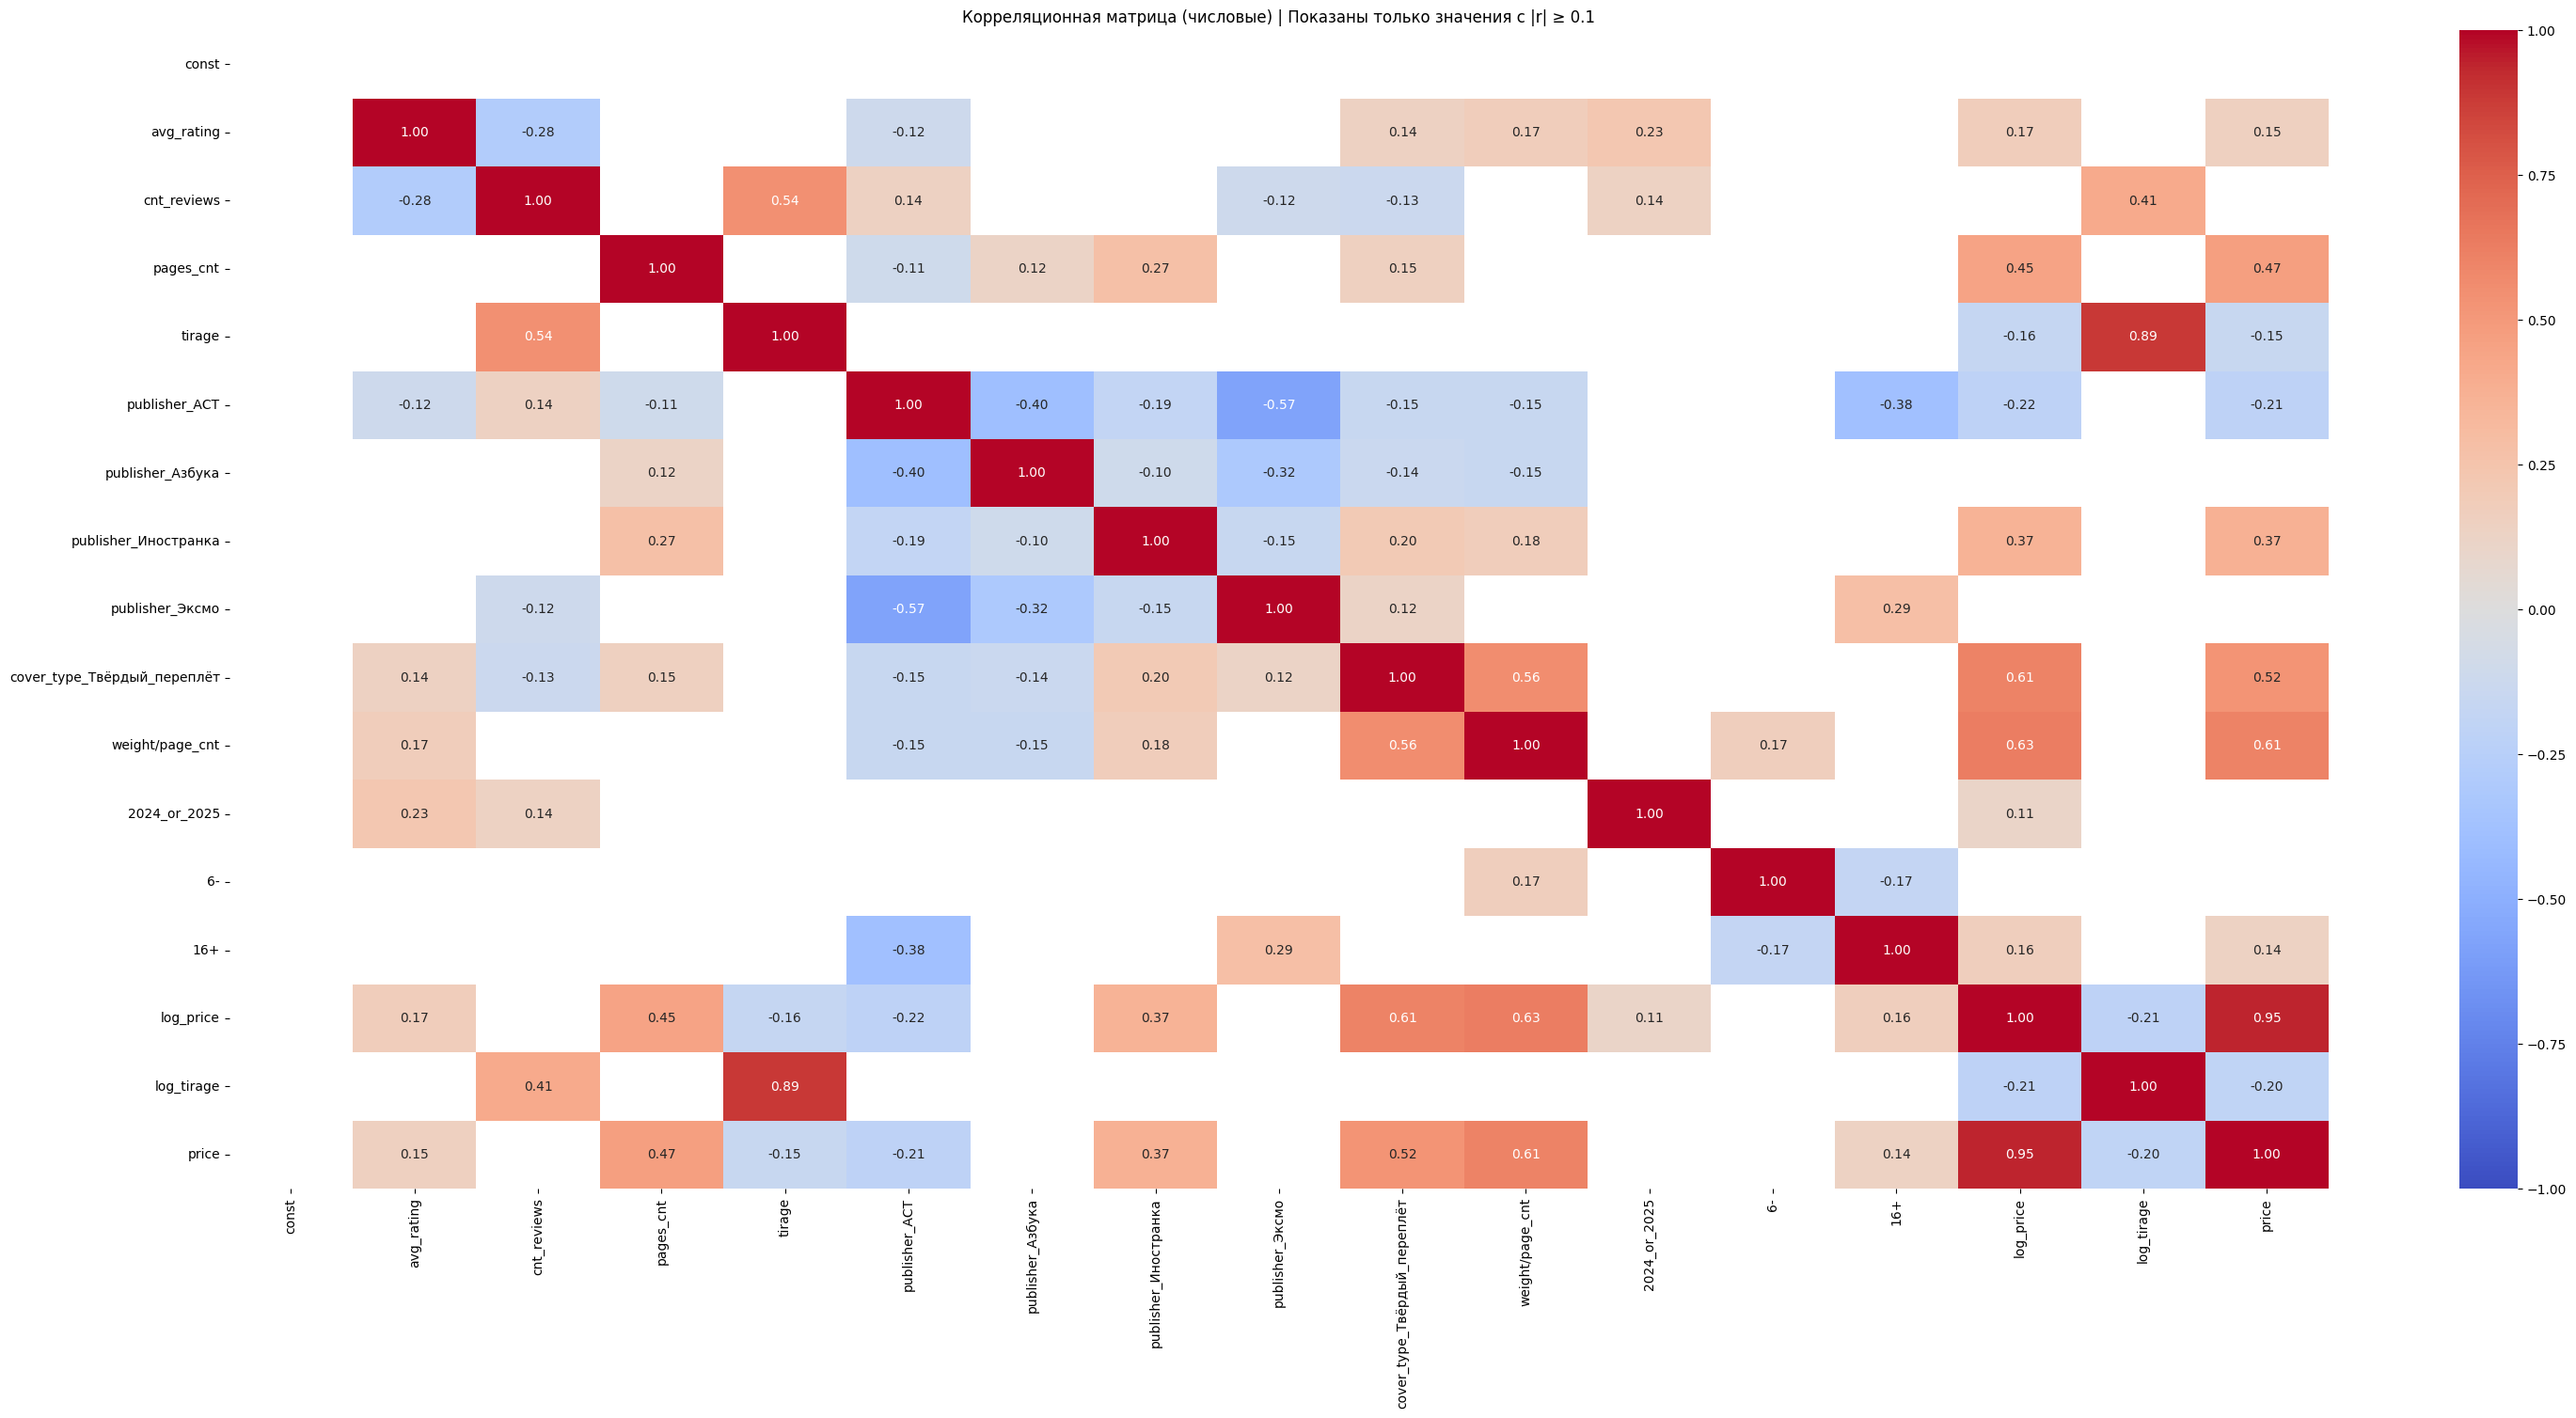

In [34]:
new_data = data.copy()
new_data['price'] = np.exp(data['log_price'])

# Вычисляем матрицу корреляций
corr_matrix = new_data.corr()

# Создаем маску для незначительных значений
mask = np.abs(corr_matrix) < 0.1

plt.figure(figsize=(36, 16))
sns.heatmap(
    corr_matrix,
    mask=mask,          
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    vmin=-1, 
    vmax=1,
)
plt.title('Корреляционная матрица (числовые) | Показаны только значения с |r| ≥ 0.1')
plt.show()

### Исследуем эндогенность

* **Гипотеза:** в модели возникает эндогенность из-за наличия обратной связи между Y и X. А конкретнее количество отзывов зависит от цена, то есть `чем меньше цена, тем больше отзывов`.
* **Инструментальная переменная:** `тираж`, как отражение популярности книги.
* **Используемый метод:** IV - метод инструментальных переменных

In [35]:
X = data.drop(['log_price', 'tirage', 'log_tirage', 'cnt_reviews'], axis=1)
y = data['log_price']

iv_model = IV2SLS(
    dependent=data['log_price'],
    exog=X,
    endog=data['cnt_reviews'],
    instruments=data['log_tirage']
).fit()

print(iv_model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              log_price   R-squared:                      0.5476
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5459
No. Observations:                3190   F-statistic:                    6094.4
Date:                Thu, May 08 2025   P-value (F-stat)                0.0000
Time:                        15:39:07   Distribution:                 chi2(12)
Cov. Estimator:                robust                                         
                                                                              
                                      Parameter Estimates                                      
                             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------------
const                           5.5164     0.1382     39.913     0.0000      5.2

In [36]:
iv_model.wu_hausman(['cnt_reviews'])

Wu-Hausman test of exogeneity
H0: Variables cnt_reviews are exogenous
Statistic: 383.7903
P-value: 0.0000
Distributed: F(1,3176)
WaldTestStatistic, id: 0x17720d730

**Вывод:** переменная действительно была эндогенной.

### Проверим релевантность и валидность:

In [37]:
Z = pd.concat((X, data['log_tirage']), axis=1)

In [38]:
dependent = data['cnt_reviews']
exog = Z

mod = sm.OLS(dependent, exog)
res = mod.fit()

print(res.summary())

# релевантность
hypotheses = '(log_tirage = 0)'
f_test = res.f_test(hypotheses)
print(f'\n{f_test}')

                            OLS Regression Results                            
Dep. Variable:            cnt_reviews   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     116.6
Date:                Thu, 08 May 2025   Prob (F-statistic):          4.13e-241
Time:                        15:39:13   Log-Likelihood:                -19555.
No. Observations:                3190   AIC:                         3.914e+04
Df Residuals:                    3177   BIC:                         3.921e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Включение инструмента в модель

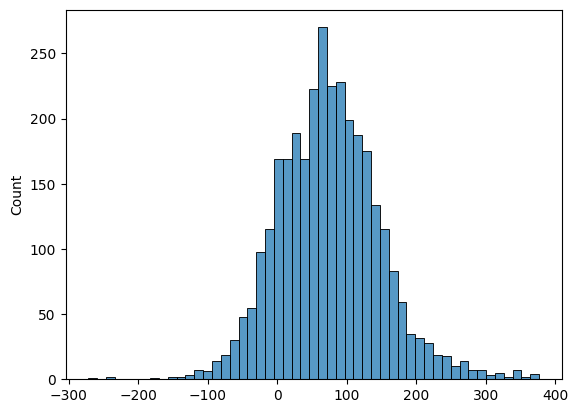

In [39]:
sns.histplot(res.fittedvalues);

In [71]:
X_exog = X.copy()

X_exog['cnt_reviews_exog'] = res.fittedvalues
X_exog

,const,avg_rating,pages_cnt,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Твёрдый_переплёт,weight/page_cnt,2024_or_2025,6-,16+,cnt_reviews_exog
0,1.0,4.1,512,1.0,0.0,0.0,0.0,0.0,0.488281,1.0,0.0,1.0,376.521735
1,1.0,4.1,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,377.026948
2,1.0,4.5,192,1.0,0.0,0.0,0.0,0.0,0.687500,1.0,0.0,1.0,316.054884
3,1.0,4.3,288,1.0,0.0,0.0,0.0,0.0,0.725694,1.0,0.0,1.0,257.481046
4,1.0,4.2,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,366.877061
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,1.0,5.0,624,0.0,0.0,0.0,1.0,1.0,1.538462,0.0,0.0,1.0,-134.933105
3186,1.0,3.7,448,0.0,0.0,0.0,1.0,1.0,1.696429,0.0,0.0,1.0,-1.822915
3187,1.0,4.3,784,0.0,0.0,1.0,0.0,1.0,1.096939,0.0,0.0,1.0,84.392983
3188,1.0,3.8,704,0.0,0.0,0.0,1.0,1.0,0.906250,0.0,0.0,1.0,6.054036


In [72]:
exog_model = sm.OLS(y, X_exog.drop(columns=['6-', 'publisher_АСТ'])).fit()
exog_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     811.3
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        16:04:46   Log-Likelihood:                -309.09
No. Observations:                3190   AIC:                             640.2
Df Residuals:                    3179   BIC:                             706.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           5.5264      0.075     73.988      0.000       5.380       5.673
avg_rating                     -0.1215      0.016     -7.386      0.000      -0.154      -0.089
pages_cnt                       0.0009   2.32e-05     40.768      0.000       0.001       0.001
publisher_Азбука               -0.0402      0.014     -2.865      0.004      -0.068      -0.013
publisher_Иностранка            0.3248      0.025     12.845      0.000       0.275       0.374
publisher_Эксмо                -0.0428      0.012     -3.510      0.000      -0.067      -0.019
cover_type_Твёрдый_переплёт     0.1975      0.012     16.186      0.000       0.174       0.221
weight/page_cnt                 0.6684      0.016     41.771      0.000       0.637       0.700
2024_or_2025                    0.1347      0.012     11.149      0.000       0.111       0.158
16+                             0.0942      0.013      7.468      0.000       0.069       0.119
cnt_reviews_exog               -0.0015   9.08e-05    -16.089      0.000      -0.002      -0.001
==============================================================================
Omnibus:                      775.300   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5347.594
Skew:                          -0.974   Prob(JB):                         0.00
Kurtosis:                       9.037   Cond. No.                     8.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Гетероскедастичность теперь

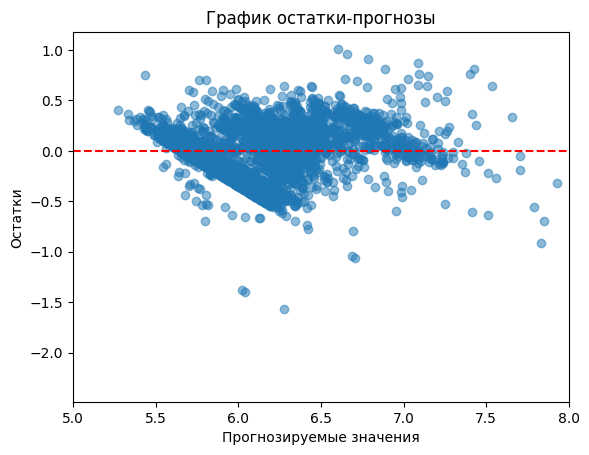

In [73]:
# Визуальный анализ (для обоих вспомогательных моделей что-то не то получается)
exog_residuals = exog_model.resid
fitted_values_ln_y = exog_model.fittedvalues

plt.scatter(fitted_values_ln_y, exog_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('График остатки-прогнозы')

plt.xlim(xmin=5, xmax=8)

plt.show()

In [60]:
# Тест Уайта
residuals = exog_model.resid
white_test = het_white(residuals, X_exog)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

LM-статистика: 2928.646393386693
p-value для LM-статистики: 0.0
F-статистика: 478.3139300405863
p-value для F-статистики: 0.0
Гетероскедастичность выявлена.
